In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.graphics.api as smg
import statsmodels.formula.api as smf

sns.set_style('darkgrid')

In [2]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    It uses Locally Weighted Scatterplot Smoothing (LOWESS) to fit a model. 
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    pred = model.fittedvalues
    influence = model.get_influence()
    resid_std = influence.resid_studentized_internal
    
    fig, ax = plt.subplots(1,2, figsize=(7.5,3.5))
    
    sns.regplot(x=pred, y=y, lowess=True, ax=ax[0], line_kws={'color':'darkorchid'})
    # I've added the ideal line (y=yhat) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[min(pred), max(pred)], 
                 ax=ax[0], color='red', ls=':')
    ax[0].set_title('Observed vs. Fitted Values')
    ax[0].set_xlabel('Fitted')
    ax[0].set_ylabel('Observed')
    
    sns.regplot(x=pred, y=resid_std, lowess=True, ax=ax[1], line_kws={'color':'darkorchid'})
    # I've added the ideal line (y=0) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0,0], ax=ax[1], color='red', ls=':')
    ax[1].set_title('Residuals vs. Fitted Values')
    ax[1].set_xlabel('Fitted')
    ax[1].set_ylabel('Standardized Residual')
    
    return fig, ax

In [3]:
def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan 
    and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    import statsmodels.stats.api as sms
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    pred = model.fittedvalues
    resid = model.resid
    resid_z = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2, figsize=(12,5.5))

    sns.regplot(x=pred, y=resid, lowess=True, ax=ax[0], line_kws={'color': 'darkorchid'})
    # I've added the ideal line (y=0) for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0,0], ax=ax[0], color='red', ls=':')
    ax[0].set_title('Residuals vs. Fitted Values')
    ax[0].set(xlabel='Fitted', ylabel='Residual')

    sns.regplot(x=pred, y=np.sqrt(np.abs(resid_z)), lowess=True, ax=ax[1], line_kws={'color': 'darkorchid'})
    # I've added the ideal line for comparison
    sns.lineplot(x=[min(pred), max(pred)], y=[0.822,0.822], ax=ax[1], color='red', ls=':')
    ax[1].set_title('Scale-Location')
    ax[1].set(xlabel='Fitted', ylabel=r'$\sqrt{|{\mathrm{Standardized~Residual}}|}$')

    # Breusch-Pagan tests if regression on 'Residuals ~ Fitted Values' has non-zero slope
    # Good for picking up trends of strictly increasing or decreasing variance
    bp_test = pd.DataFrame(sms.het_breuschpagan(resid, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    # Goldfeld-Quandt tests if variance on left half of residual plot is equal to variance on right half
    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resid, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')
    plt.show()

In [4]:
def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 5 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    import scipy.stats as stats
    import statsmodels.graphics.api as smg
    import statsmodels.stats.api as sms
    
    fig, ax = plt.subplots(figsize=(4.5,4))
    smg.qqplot(data=model.resid, line='45', fit=True, ax=ax);
    ax.set_title('Q-Q plot');
    resid_z = model.get_influence().resid_studentized_internal

    sw = stats.shapiro(model.resid)
    dp = stats.normaltest(model.resid)
    jb = stats.jarque_bera(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    lf = sms.lilliefors(model.resid)
    ks = stats.kstest(resid_z, 'norm')
    
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f"D'Agostino-Pearson Omnibus test ---- statistic: {dp[0]:.4f}, p-value: {dp[1]:.4f}")
    print(f'Lilliefors test ---- statistic: {lf[0]:.4f}, p-value: {lf[1]:.4f}')
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, '\
          'the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
    plt.show()

In [5]:
def autocorrelation_plot(model):
    import statsmodels.tsa.api as smt
    fig, ax = plt.subplots(figsize=(12,6))
    acf = smt.graphics.plot_acf(model.resid, lags=40, alpha=0.05, ax=ax)

# Pie Sales revisited
Let's look  at an example where the model passes the assumptions

In [6]:
pie = pd.read_csv('pie.csv')
pmodel = smf.ols('Qsales ~ Price + Advert + CompPrice + Income + C(Quarter)', data=pie).fit()
print(pmodel.summary2())

                     Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.905     
Dependent Variable:    Qsales             AIC:                  846.3803  
Date:                  2023-08-21 17:18   BIC:                  861.3499  
No. Observations:      48                 Log-Likelihood:       -415.19   
Df Model:              7                  F-statistic:          64.67     
Df Residuals:          40                 Prob (F-statistic):   8.40e-20  
R-squared:             0.919              Scale:                2.2899e+06
--------------------------------------------------------------------------
                   Coef.     Std.Err.    t    P>|t|     [0.025     0.975] 
--------------------------------------------------------------------------
Intercept       -11250.7507 5327.4263 -2.1119 0.0410 -22017.8809 -483.6204
C(Quarter)[T.2]   -250.6891  619.7615 -0.4045 0.6880  -1503.2739 1001.8956
C(Quarter)[T.3]   1487.1934  650.6815  2.2856 0

## Assumption 1 - Mean residual is 0

Side note: all four assumptions can be summarized as the following.

Residuals are i.i.d. N(0,$\sigma$).

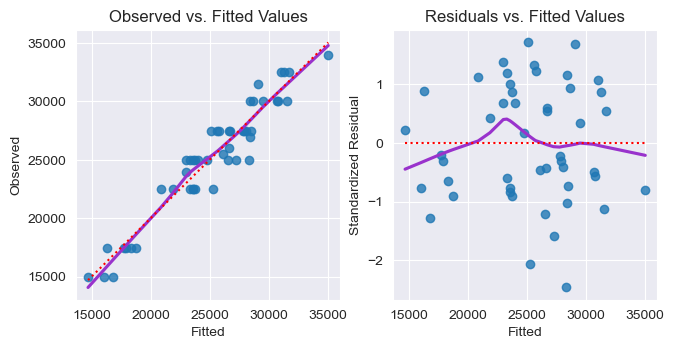

In [7]:
fig, ax = linearity_test(pmodel, pie['Qsales'])
plt.show()

## Assumption 2: Residual variance is constant


 Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  6.138581
p-value                        0.523664
f-value                        0.837946
f p-value                      0.562623

 Goldfeld-Quandt test ----
                value
F statistic  0.351665
p-value      0.978012

 Residuals plots ----


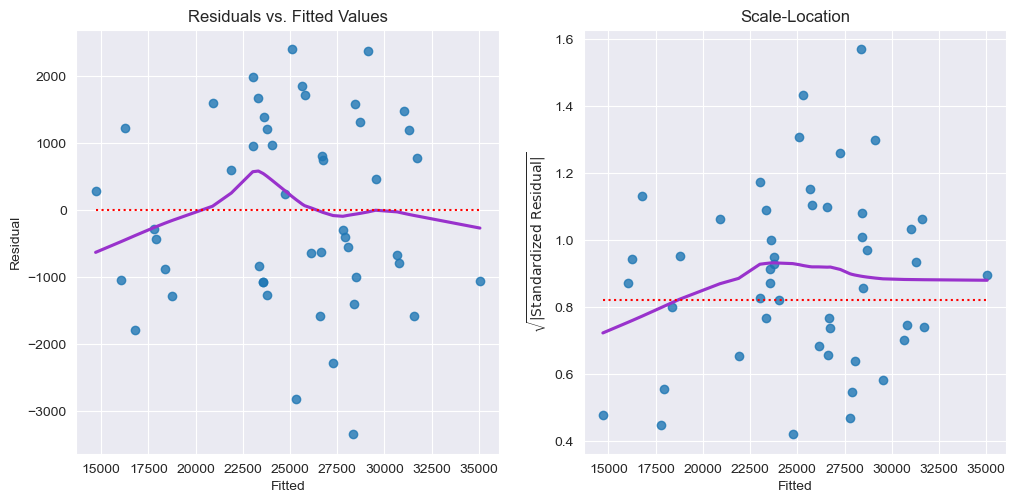

In [8]:
homoscedasticity_test(pmodel)

## Assumption 3: Residuals are normally distributed

Shapiro-Wilk test ---- statistic: 0.9650, p-value: 0.1608
D'Agostino-Pearson Omnibus test ---- statistic: 1.7652, p-value: 0.4137
Lilliefors test ---- statistic: 0.1005, p-value: 0.2586
Jarque-Bera test ---- statistic: 1.3336, p-value: 0.5133605290955945
Kolmogorov-Smirnov test ---- statistic: 0.1031, p-value: 0.6496
Anderson-Darling test ---- statistic: 0.6563, 5% critical value: 0.7340
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


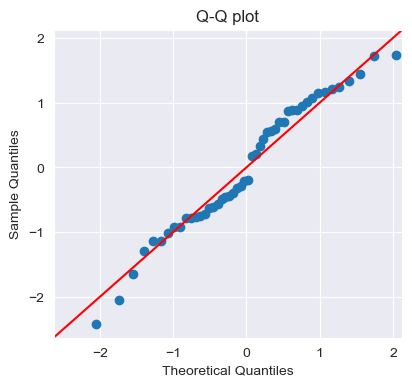

In [9]:
normality_of_residuals_test(pmodel)

## Assumption 4: Residuals are independent

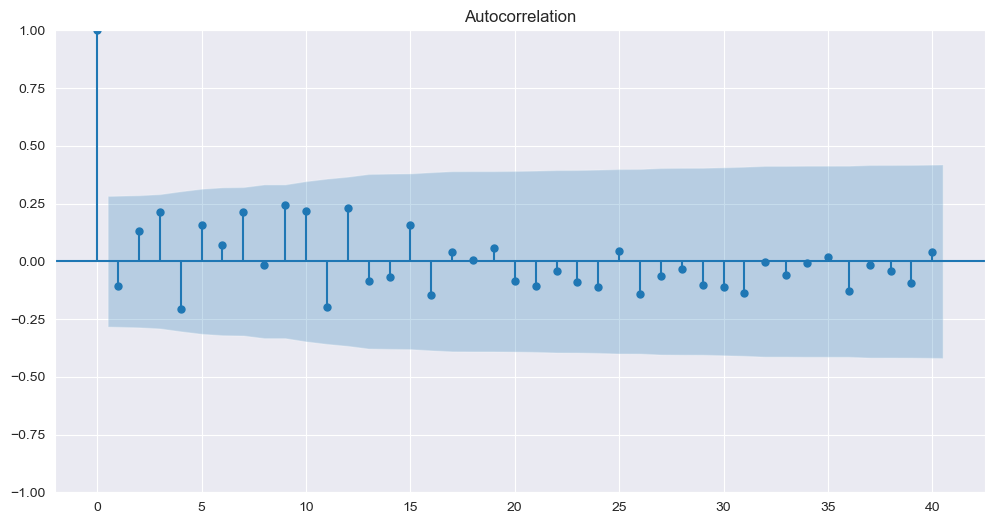

In [10]:
# Assuming that the index of the data has any ordered meaning
autocorrelation_plot(pmodel)

## Not in video but important: Multicollinearity

This isn't an assumption of regression, but it can impact our ability to draw conclusions from the model. 

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [14]:
y, X = dmatrices('Qsales ~ Price + Advert + CompPrice + Income + C(Quarter)', 
                 data=pie, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, ii) \
              for ii in range(X.shape[1])]
vif['features'] = X.columns
print(vif)

          VIF         features
0  594.912068        Intercept
1    1.509622  C(Quarter)[T.2]
2    1.664010  C(Quarter)[T.3]
3    1.547569  C(Quarter)[T.4]
4    1.203216            Price
5    1.809909           Advert
6    1.161887        CompPrice
7    1.572647           Income


None of the values are of concern. Recall that the VIF for the intercept is not a worry. Values above 5 are moderately problematic, and values above 10 indicate serious multicollinearity.